# UNet in JAX

## Import relevant packages

In [ ]:
import jax
import jax.numpy as jnp
import jax.tree_util as jtu
import equinox as eqx
import optax
import matplotlib.pyplot as plt
from typing import Callable

## UNet introduction

1. We will be solving the 1D Poisson's equation via UNet
2. The standard effective solvers for Poisson's equations employ multigrid methods with varying resolution and this is analogous to the UNet architecture which is an encoder-decoder with varying channels within the respective network blocks
3. UNet can be thought of as a generalized nonlinear version of the Singular Value Decomposition (SVD)
4. The linear SVD takes input data living in a higher-dimensional space, then compresses it down to a lower-dimensional space and then generates a recontructed higher-dimensional version from the dominant lower-dimensional modes. This can be thought of as a single-layer linear encoder-decoder. This operation can be generalized by first considering a non-linear transform and then building a nested architecture containing compositions of such blocks with varying dimensions

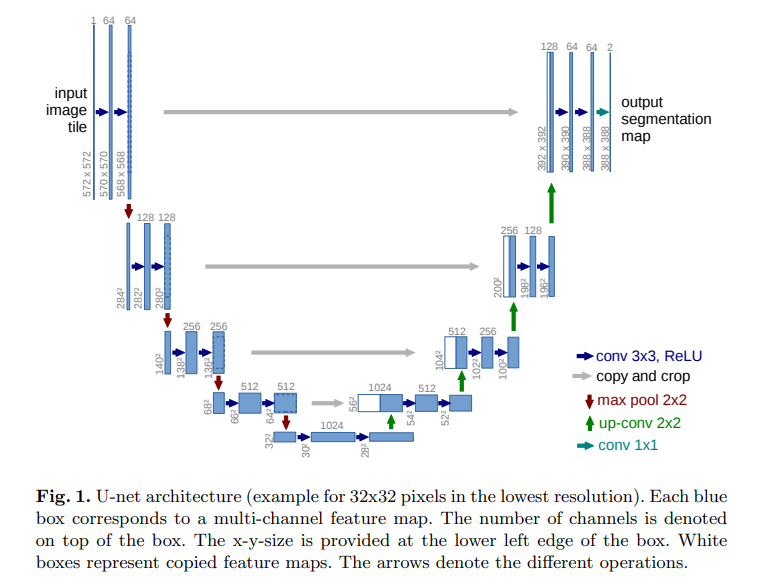

## Deviations from typical UNet

1. The conventional UNet is applied to a matrix whereas here we will apply it to a vector
2. We will use a linear convolution for down-scaling instead of the max pooling operation
3. We will use "same" padding to never have issues with spatial sizes
4. We will not apply any normalization layers for simplicity
5. We will use a variable number of levels

## Set plotting background to dark mode

In [ ]:
plt.style.use("dark_background")

## Playing around with diagonal matrix commands

In [ ]:
jnp.diag(jnp.ones(3), -1)

In [ ]:
-2*jnp.diag(jnp.ones(3), 0)

In [ ]:
-2*jnp.diag(jnp.ones(4), 0)

In [ ]:
jnp.diag(jnp.ones(3), 1)

In [ ]:
jnp.diag(jnp.ones(3), -1) -2*jnp.diag(jnp.ones(4), 0) + jnp.diag(jnp.ones(3), 1)

## Data generation

In [ ]:
num_points = 32
num_samples = 1000
domain_extent = 5.0

grid = jnp.linspace(0, domain_extent, num_points+2)[1:-1]
dx = grid[1] - grid[0]

A = jnp.diag(jnp.ones(num_points-1), -1) - 2*jnp.diag(jnp.ones(num_points), 0) + jnp.diag(jnp.ones(num_points-1), 1)
A = A / dx**2

def solve_poisson(f):
    return jnp.linalg.solve(A, -f)

def create_discontinuity(key):
    limit_1_key, limit_2_key = jax.random.split(key)
    lower_limit = jax.random.uniform(limit_1_key, (), minval=0.2*domain_extent, maxval=0.4*domain_extent)
    upper_limit = jax.random.uniform(limit_2_key, (), minval=0.6*domain_extent, maxval=0.8*domain_extent)

    discontinuity = jnp.where((grid >= lower_limit) & (grid <= upper_limit), 1.0, 0.0)

    return discontinuity

primary_key = jax.random.PRNGKey(0)
keys = jax.random.split(primary_key, num_samples)
force_fields = jax.vmap(create_discontinuity)(keys)
displacement_fields = jax.vmap(solve_poisson)(force_fields)

## Notes on Data generation

1. We would like to work with 1000 data samples and have the domain extend from 0 to 5 units
2. We would like to discretize our grid into 32 points - we use linspace to generate a grid with 34 points and exclude the boundary points
3. We next compute the spacing between the grid points and assign the computed value to a variable named dx
4. We then generate a matrix with the main diagonals and its adjacent diagonals populated, followed by normalization
5. Next, the function to compute the reference solution is defined with the name "solve poisson"
6. Since we are interested in working with 1000 data samples - we would like to create 1000 samples of force field data where each force field is a top hat function - for this we define the "create discontinuity" function
7. The "create discontinuity" function takes in a scalar-valued input in the form of a random key, splits this key into two keys and uses these newly generated keys to pull out lower and upper limits for the top hat function from uniform distributions. Once these limits are pulled out, the top hat is constructed using jnp.where
8. We then generate a random key to start with and use it to generate 1000 keys for each sample
9. Next, we would like to generate 1000 force field samples using our "create discontinuity" function. However, this function was designed for scalar-valued inputs. Therefore, we use vmap to first vectorize this function and then apply it to the keys array containing the 1000 generated keys
10. Finally, we generate the ground truth displacement fields from the force fields array using the reference solution generator - "solve_poisson". Again, this function deals with a single force field whereas we have a vector or array of force fields. Hence, we use vmap again

## Shapes of force and displacement fields

In [ ]:
force_fields.shape

In [ ]:
displacement_fields.shape

## Notes on shapes

1. UNet is a CNN architecture
2. The shape convention for an input tensor fed to a CNN is [batch_size, num_channels, spatial_dimensions]
3. Our current shape is of the form [batch_size, spatial_dimensions]
4. Thus, we need to insert a dimension for number of channels at the appropriate location
5. We will achieve this by utilization of None
6. Also note that we are developing a UNet for solving a 1D problem which is why our spatial dimensions has a single entry - 32

## Reshape

In [ ]:
force_fields = force_fields[:, None, :]
displacement_fields = displacement_fields[:, None, :]

## Check shapes after reshaping

In [ ]:
force_fields.shape

In [ ]:
displacement_fields.shape

## Extract first sample for visualization

In [ ]:
force_field_first = force_fields[0, 0, :]
displacement_field_first = displacement_fields[0, 0, :]

## Check shapes

In [ ]:
force_field_first.shape

In [ ]:
displacement_field_first.shape

In [ ]:
force_fields[0,0].shape

In [ ]:
displacement_fields[0,0].shape

## Notes on extracting first sample and shapes

The first sample can also be extracted via the command field_array[0,0]

## Visualize first sample

In [ ]:
plt.figure()
plt.plot(grid, force_field_first, label="force field")
plt.plot(grid, displacement_field_first, label="displacement field")
plt.legend()
plt.xlabel("x")
plt.title("Visualize data for the first sample")

## Notes on the plot

1. The boundary points have been excluded from the grid and therefore are not visiable in the plots
2. We can think of a string clamped at two ends and applying a constant force to the central part of the string by plucking it
3. Such a force will lead to a symmetric displacement with non-zero displacements with regions where the force is zero and maximum displacement at the center of the domain
4. Let us now plot more than one sample

## Extracting multiple samples (first 10 samples)

In [ ]:
force_fields_multiple = force_fields[:10, 0]
displacement_fields_multiple = displacement_fields[:10, 0]

## Check shapes of array containing multiple samples

In [ ]:
force_fields_multiple.shape

In [ ]:
displacement_fields_multiple.shape

## Compare with shape for visualizing only the first sample

In [ ]:
force_field_first.shape

## Notes on shape comparison between single and multiple samples

1. We can see that the earlier shape was of the form (32,) or (32, Nothing)
2. Here the shape is of the form (10,32)
3. To ensure that the shape format is consistent we would need to transpose the current array

## Plot multiple samples

In [ ]:
plt.figure()
plt.plot(grid, force_fields_multiple.T)

In [ ]:
plt.figure()
plt.plot(grid, displacement_fields_multiple.T)

In [ ]:
fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(12, 20))
for i in range(10):
    ax_force = axes[i, 0]
    ax_displacement = axes[i, 1]

    ax_force.plot(force_fields_multiple[i])
    ax_displacement.plot(displacement_fields_multiple[i], 'y')

    if i == 0:
        ax_force.set_title('Force Field')
        ax_displacement.set_title('Displacement Field')

    ax_force.set_ylabel(f'Sample {i+1}')
    ax_force.set_xticks([])
    ax_displacement.set_xticks([])

# Add a common xlabel and ylabel
fig.text(0.5, 0.04, 'Index', ha='center')
fig.text(0.04, 0.5, 'Value', va='center', rotation='vertical')

plt.tight_layout(rect=[0.04, 0.04, 1, 1])
plt.show()

## Plot the arrrays for multiple samples without the transpose to see what happens

In [ ]:
plt.figure()
plt.plot(grid, force_fields_multiple)

## Notes on plotting multiple samples array without the transpose

As can be seen, we get an error associated with shape inconsistency between the grid and the force fields

## 4:1 Test-Train split

In [ ]:
split_idx = num_samples // 5 * 4
train_x, test_x = force_fields[:split_idx], force_fields[split_idx:]
train_y, test_y = displacement_fields[:split_idx], displacement_fields[split_idx:]

## Check shape after performing Test-Train split

In [ ]:
train_x.shape, train_y.shape

In [ ]:
test_x.shape, test_y.shape

## Notes on Test-Train split

1. First we divide the number of samples into five parts and then extract the index corresponding to the 4:1 split
2. Next we use split the force and displacement fields by generating arrays with indexing up to the split index for training data and from the split index for the test data

## Double conv block for UNet

In [ ]:
class DoubleConv(eqx.Module):
    conv_1: eqx.nn.Conv
    conv_2: eqx.nn.Conv
    activation: Callable

    def __init__(self, num_spatial_dims: int, in_channels: int, out_channels: int, activation: Callable, *, key):
        c_1_key, c_2_key = jax.random.split(key)
        self.conv_1 = eqx.nn.Conv(num_spatial_dims, in_channels, out_channels, kernel_size=3, padding=1, key=c_1_key)
        self.conv_2 = eqx.nn.Conv(num_spatial_dims, out_channels, out_channels, kernel_size=3, padding=1, key=c_2_key)
        self.activation = activation

    def __call__(self, x: jax.Array):
        x = self.conv_1(x)
        x = self.activation(x)
        x = self.conv_2(x)
        x = self.activation(x)
        return x

## Notes on Double conv block for UNet

1. We first start be defining a class called "DoubleConv" that inherits from equinox's Module
2. The double conv block is composed of two convolutional layers and we specify that these convolutional layers will be of the type eqx.nn.Conv at the start of the class and also specify that the activation function will be Callable object
3. A Callable object in Python is anything that can be called via the paranthesis () syntax. For example, functions and classes can be called using the paranthesis () but integers and strings cannot be called
4. We next create the initialization block (constructor) where we require the number of spatial dimensions, number of input and output channels, the activation function and a random key along with the self keyword for initialization
5. The inputs to the initialization block are then used to initialize two convolutional layers and the activation function. It is worth noting that the the number of out channels of the first layers are equal to the number of in channels for the second layer. In addition, the random key is split into two separate random keys to initialize both the conv layers respectively
6. After the initialization block, we have a block for the forward pass which is defined via the call keywork and takes in as input a jax Array
7. The forward block simply performs iterative nonlinear function composition as is typical of neural network forward pass operations

## Notes on the star (*) in the initialization block

1. The star (*) means that any subsequent arguments to the constructor must be passed as keyword arguments and not positional arguments
2. As a concrete example, during initialization - we need to specify the key input as key = key_input_value
3. Example use - "double_conv = DoubleConv(2, 3, 64, activation_function, key=key)"

## Notes on the "init" method

The "init" method is called a "constructor" and is a special method used to initialize an instance of the class

## Define UNet class

In [ ]:
class UNet(eqx.Module):
    lifting: DoubleConv
    down_sampling_blocks: list[eqx.nn.Conv]
    left_arc_blocks: list[DoubleConv]
    right_arc_blocks: list[DoubleConv]
    up_sampling_blocks: list[eqx.nn.Conv]
    projection: eqx.nn.Conv

    def __init__(self, num_spatial_dims:int, in_channels:int, out_channels:int, hidden_channels:int, num_levels:int, activation:Callable, *, key):
        key, lifting_key, projection_key = jax.random.split(key, 3)
        self.lifting = DoubleConv(num_spatial_dims, in_channels, hidden_channels, activation, key=lifting_key)
        self.projection = eqx.nn.Conv(num_spatial_dims, hidden_channels, out_channels, kernel_size=1, key=projection_key)

        channel_list = [hidden_channels * 2**i for i in range(0, num_levels+1)]

        self.down_sampling_blocks = []
        self.left_arc_blocks = []
        self.right_arc_blocks = []
        self.up_sampling_blocks = []

        for (upper_level_channels, lower_level_channels) in zip(channel_list[:-1], channel_list[1:]):
            key, down_key, left_key, right_key, up_key = jax.random.split(key, 5)
            self.down_sampling_blocks.append(eqx.nn.Conv(num_spatial_dims, upper_level_channels, upper_level_channels, kernel_size=3, stride=2, padding=1, key=down_key))
            self.left_arc_blocks.append(DoubleConv(num_spatial_dims, upper_level_channels, lower_level_channels, activation, key=left_key))
            self.right_arc_blocks.append(DoubleConv(num_spatial_dims, lower_level_channels, upper_level_channels, activation, key=right_key))
            self.up_sampling_blocks.append(eqx.nn.ConvTranspose(num_spatial_dims, lower_level_channels, upper_level_channels, kernel_size=3, stride=2, padding=1, output_padding=1, key=up_key))          

    def __call__(self, x: jax.Array):
        x = self.lifting(x)
        x_skips = []

        # Left part of the arc
        for down, left in zip(self.down_sampling_blocks, self.left_arc_blocks):
            x_skips.append(x)
            x = down(x)
            x = left(x)

        # Right part of the arc
        for right, up in zip(reversed(self.right_arc_blocks), reversed(self.up_sampling_blocks)):
            x = up(x)
            x = jnp.concatenate([x, x_skips.pop()], axis=0)
            x = right(x)

        x = self.projection(x)
        
        return x

## Notes on UNet

Add notes

## Instantiate UNet

In [ ]:
poisson_solver_unet = UNet(1, 1, 1, 32, 2, jax.nn.relu, key=jax.random.PRNGKey(0))

## Notes on Instantiating UNet

1. We would like our UNet to take in a force-field and output a displacement-field
2. Since both fields are single channel fields, we will set the number of in and out channels = 1
3. We are solving a one dimensional problem, so we will set the number of spatial dimensions = 1
4. We use a two level UNet as opposed to thr standard UNet and therefore set the number of levels = 2
5. We will use 32 hidden channels and use a ReLU activation
6. Recall that the key comes after the star (*) and therefore needs to be specified as a keyword argument
7. The implementation is successful and we will now proceed to counting parameters

## Count UNet parameters

In [ ]:
def count_parameters(model: eqx.Module):
    return sum(p.size for p in jtu.tree_leaves(eqx.filter(model, eqx.is_array)))

In [ ]:
count_parameters(poisson_solver_unet)

## Notes on counting UNet parameters

1. The count parameters function takes as input a model which is desired to be an isntance of eqx.Module as specified by the type hint
2. First a filter is used to extract a PyTree containing only the arrays from the model (weights and biases of the neural network)
3. Next the leaves are extracted from the tree using jtu.tree_leaves
4. Finally, we count the number of leaves and add them up using a Generator expression to get the model parameter count
5. Generator expressions create Generator objects which are special iterables that provide memory-efficient ways of working with sequences

## Examples of Generator expressions in Python

In [ ]:
squares = (x**2 for x in range(1,6))

In [ ]:
type(squares)

In [ ]:
squares

In [ ]:
for square in squares:
    print(square)

In [ ]:
even_squares = (y**2 for y in range(1,6) if y%2==0)

In [ ]:
type(even_squares)

In [ ]:
for even_square in even_squares:
    print(even_square)

## Notes on Generator expressions in Python

1. Generator expressions in Python create generator objects
2. The syntax = (expression for item in iterable if condition)
3. In the above syntax, the condition is not necessary as can be seen from the examples above
4. Generator objects are special iterables that provide memory-efficient ways of working with sequences

## Initial prediction

In [ ]:
jax.vmap(poisson_solver_unet)(train_x)

## Notes on Initial Prediction

1. Equinox modules are designed for single batch by default
2. Thus we need to use vmap to vectorize our network that is an instance of an equinox module so that it can process train_x which is a batch input

## Save parameter count

In [ ]:
parameter_count = count_parameters(poisson_solver_unet)
print(parameter_count)

## Data Loader

In [ ]:
def dataloader(data, *, batch_size:int, key):

    """
    Loop generator over the data. The data can be a PyTree or an Array.
    For supervised learning problems you can also hand over a tuple of Arrays
    (=PyTree).
    """

    n_samples_list = [a.shape[0] for a in jtu.tree_leaves(data)]

    if not all(n == n_samples_list[0] for n in n_samples_list):
        raise ValueError("All arrays / PyTree leaves must have the same number of samples. (Leading Array exists)")
        
    n_samples = n_samples_list[0]

    n_batches = int(jnp.ceil(n_samples / batch_size))

    permutation = jax.random.permutation(key, n_samples)

    for batch_id in range(n_batches):
        start = batch_id * batch_size
        end = min((batch_id + 1) * batch_size, n_samples)

        batch_indices = permutation[start:end]

        sub_data = jtu.tree_map(lambda a: a[batch_indices], data)
    
        yield sub_data

## Notes on Data Loader (based on my working knowledge of it)

1. Let us assume that data is a tuple formed by features of the training data set (for example - train x and train y)
2. The n_samples_list is a list containing the number of training samples corresponding to each features of the data tuple
3. The generator expression in the line of code after n_samples_list checks if each features of the training data set has the same number of samples
4. Next the number of batches is computed and stored in n_batches
5. Then the permutation line of code takes an array of the form [0, 1, 2, .., n_samples-1] and shuffles the entries randomly
6. Next we iterate over the number of batches and generate start and end indices based on the batch size
7. However instead of slicing the data via an indices array of the form [0, 1, 2, .., n_samples-1], we slice the data based on the shuffled indices array generated via the permutation operation
8. The sub_data line of code extracts a batch of the desired size from the training data using indices given by the randomly shuffled array
9. The current batch is then returned to the generator function via the yield keyword

## Training Loop

In [ ]:
optimizer = optax.adam(3e-4)
opt_state = optimizer.init(eqx.filter(poisson_solver_unet, eqx.is_array))

def loss_fn(model, x, y):
    y_pred = jax.vmap(model)(x)
    mse = jnp.mean(jnp.square(y_pred - y))
    return mse

@eqx.filter_jit
def update_fn(model, state, x, y):
    loss, grad = eqx.filter_value_and_grad(loss_fn)(model, x, y)
    updates, new_state = optimizer.update(grad, state, model)
    new_model = eqx.apply_updates(model, updates)
    return new_model, new_state, loss

loss_history = []

shuffle_key = jax.random.PRNGKey(151)

n_epochs = 100

for epoch in range(n_epochs):
    shuffle_key, subkey = jax.random.split(shuffle_key)
    
    for batch in dataloader((train_x, train_y), batch_size=32, key=subkey):
        poisson_solver_unet, opt_state, loss = update_fn(poisson_solver_unet, opt_state, *batch)
        loss_history.append(loss)
        print(epoch, loss)

## Notes on Training Loop

1. We first setup up the ADAM optimizer with a learning rate of 3e-4
2. Next we extract the parameters (weights and biases) of the neural network using equinox's array filter and use these parameters to initialize the optimizer state
3. The optimizer state carries information required for the optimization algorithm like squares of the gradient and associated quantities
4. Next we define a standard mean-squared error loss function which takes as input the neural network model and the data fitting variables. Note that we use vmap so that the model can be vectorized to operate over a batch
5. Then we define a function to carry out a single optimization step and wrap it in the jit compiler decorator for speed-up
6. The single optimization step function first extracts the current loss function value and its gradient with respect to the neural network parameters using equinox's filter and grad command. By default, this command filters for model parameters that are doubles and performs gradients with respect to them - this is an indirect way of extracting the weights and biases of the network. Note that the filter and grad does require all the inputs to the loss function for this command - model, x, y
7. Then updates to the neural network model and the new optimizer state are computed
8. Finally the updates are applied to the neural network model parameters (weights and biases) and the quantities of interest are returned by the optimization step function
9. Next we initialize an empty list to record the loss history and generate a random key as this is required by the data loader
10. We then perform optimization iteratively using a nested loop. The outer loop iterates over the epochs and the inner loop iterates over the batches in the training dataset via the data loader
11. Finally, note that update fn takes in four arguments - model, state, x, y whereas the batch in the data loader is a tuple of the form (x, y). Thus, we need to unpack the batch tuple (x, y) to x and y before using it as input to update fn. This unpacking is achieved via the star (*) in front of batch

## Inspect Loss history

In [ ]:
plt.figure()
plt.semilogy(loss_history)

## Generate Data for Final Prediction on test sample

In [ ]:
test_sample_idx = 1
test_sample_force_field = force_fields[test_sample_idx]
test_sample_ground_truth = displacement_fields[test_sample_idx]

## Check shape of Generated Data

In [ ]:
test_sample_force_field.shape, test_sample_ground_truth.shape

## Reshape data for CNN input tensor shape requirements

In [ ]:
test_sample_force_field = test_sample_force_field[None, :]
test_sample_force_field.shape

## Generate Final Prediction

In [ ]:
test_sample_prediction = jax.vmap(poisson_solver_unet)(test_sample_force_field)

## Visualize Final Prediction on test sample

In [ ]:
plt.figure()
plt.plot(grid, test_sample_force_field.squeeze(), 'y', label="input")
plt.plot(grid, test_sample_ground_truth.squeeze(), 'b--', label="ground truth")
plt.plot(grid, test_sample_prediction.squeeze(), 'r', label="prediction")
plt.legend()
plt.xlabel("x")
plt.title("Visualize results for test sample")

## Test error metric

In [ ]:
def normalized_L2_norm(pred, ref):
    diff_norm = jnp.linalg.norm(pred - ref)
    ref_norm = jnp.linalg.norm(ref)
    return diff_norm / ref_norm

## Generate Test Prediction on entire Test dataset

In [ ]:
test_predictions = jax.vmap(poisson_solver_unet)(test_x)

## Generate Test errors

In [ ]:
test_errors = jax.vmap(normalized_L2_norm)(test_predictions, test_y)

In [ ]:
test_errors.shape

In [ ]:
jnp.mean(test_errors), jnp.std(test_errors)

## Notes on Test errors analysis

1. The test error for a given sample is computed via the normalized L2 norm function which takes as input two displacement field vectors
2. Since we need to apply our neural network model to the entire test batch, we use vmap as usual
3. The test errors for the entire test batch is again computed via vmap, this time applied on the normalized L2 norm function
4. As expected the size of test errors is 200 which equals the size of the test dataset
5. We compute basic statistics - mean and standard deviation for the test errors array and the values demonstrate good performance by the UNet